In [ ]:
!pip install keras

In [13]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SpatialDropout2D,Conv2DTranspose,Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


In [6]:
def conv_block(x, n_base, batch_normalization):
    
    x = Conv2D(filters=n_base, kernel_size=(3,3), 
                        strides=(1,1),padding='same')(x)
    if (batch_normalization):
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=n_base, kernel_size=(3,3), 
                        strides=(1,1),padding='same')(x)
    if (batch_normalization):
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [15]:
def downsample_block(x, n_base, batch_normalization, dropout):
    f = conv_block(x, n_base, batch_normalization)
    p = layers.MaxPool2D(pool_size = (2,2))(f)
    if(dropout):
        p = layers.Dropout(0.2)(p)
        
    return f, p

In [5]:
def upsample_block(x, f, n_base, batch_normalization, dropout):
    
    x = Conv2DTranspose(filters=n_base, kernel_size=(2,2), 
                         strides=(2,2),padding='same')(x)
    x = Concatenate()([x,f])
    if(dropout):
        x = layers.Dropout(0.2)(x)
    x = conv_block(x, n_base, batch_normalization)
        
    return x

In [7]:
def get_unet(img_w, img_h, img_ch, n_base, LR, batch_normalization, dropout):

    
    
    ## Encoder part
#     model = Sequential()
    inputs = layers.Input((img_w, img_h, img_ch))
    
    f1, p1 = downsample_block(inputs, n_base, batch_normalization, dropout)
    f2, p2 = downsample_block(p1, n_base*2, batch_normalization, dropout)
    f3, p3 = downsample_block(p2, n_base*4, batch_normalization, dropout)
    f4, p4 = downsample_block(p3, n_base*8, batch_normalization, dropout)
    
    
    ## Bottleneck
    bottleneck = conv_block(p4, n_base*16, batch_normalization)
    
    ## Decoder part
    p5 = upsample_block(bottleneck, f4, n_base*8, batch_normalization, dropout)
    p6 = upsample_block(p5, f3, n_base*4, batch_normalization, dropout)
    p7 = upsample_block(p6, f2, n_base*2, batch_normalization, dropout)
    p8 = upsample_block(p7, f1, n_base, batch_normalization, dropout)

    
    ## 1 Convo layer
    p9 = Conv2D(filters=1, kernel_size=(1,1), 
                            padding='same')(p8)
    outputs = Activation('sigmoid')(p9)
    

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    
    return model


In [8]:
!pip install scikit-image

In [9]:
## Task1a) Lung segmentation in chest X-ray images:
import os
from random import shuffle
from skimage.io import imread
from skimage.transform import resize


image_path = '/DL_course_data/Lab3/X_ray/Image' 
mask_path = '/DL_course_data/Lab3/X_ray/Mask'



In [10]:
def load_data(image_path,mask_path):
    
    image_list = os.listdir(image_path)
    mask_list = os.listdir(mask_path)
    
    images = []
    masks = []


    for image in image_list:
        img = imread(os.path.join(image_path, image), as_gray=True)  # "as_grey"
        img = resize(img, (256, 256), anti_aliasing=True).astype('float32')

        mask_img = imread(os.path.join(mask_path, image), as_gray=True)
        mask = resize(mask_img, (256, 256), anti_aliasing=True).astype('float32')

        images.append(img)
        masks.append(mask)
        
    ## Load data in traditional way
    img_train, img_val, mask_train, mask_val = train_test_split(images, masks, shuffle = True,
                                                      test_size = 0.2)
    img_train = np.expand_dims(img_train, axis = -1)
    img_train = np.array(img_train)
    img_val = np.expand_dims(img_val, axis = -1)    
    img_val = np.array(img_val)
    mask_train = np.expand_dims(mask_train, axis = -1)
    mask_train = np.array(mask_train)
    mask_val = np.expand_dims(mask_val, axis = -1)
    mask_val = np.array(mask_val)
    
    return img_train, img_val, mask_train, mask_val
    

In [11]:
from tensorflow.keras import backend as K
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [16]:
n_base =32
LR = 1e-4
batch_normalization = False
dropout = True
epochs = 150
Metric= 'Dice Coefficient'
batch_size = 8

img_w, img_h = 256,256
img_ch = 1

model = get_unet(img_w, img_h, img_ch, n_base, LR, 
                 batch_normalization, dropout)

# run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)

## BCE
# model.compile(loss = 'binary_crossentropy',          # Model Compiling   
#               optimizer = Adam(lr = LR),
#               metrics = [dice_coef])
## Dice
model.compile(loss = [dice_coef_loss],          # Model Compiling   
              optimizer = Adam(lr = LR),
              metrics = [dice_coef])



: 

: 

In [13]:
img_train, img_val, mask_train, mask_val = load_data(image_path,mask_path)


In [16]:
## Task 1 a-d tasks

model_history = model.fit(img_train,mask_train,
                            validation_data=(img_val,mask_val),
                            epochs = epochs, batch_size = batch_size,
                            verbose=1)


Epoch 1/150
24/24 [==============================] - 12s 250ms/step - loss: 0.6155 - dice_coef: 0.3850 - val_loss: 0.5999 - val_dice_coef: 0.4004
Epoch 2/150
24/24 [==============================] - 4s 160ms/step - loss: 0.5300 - dice_coef: 0.4700 - val_loss: 0.5182 - val_dice_coef: 0.4823
Epoch 3/150
24/24 [==============================] - 4s 161ms/step - loss: 0.4845 - dice_coef: 0.5160 - val_loss: 0.4629 - val_dice_coef: 0.5377
Epoch 4/150
24/24 [==============================] - 4s 160ms/step - loss: 0.4181 - dice_coef: 0.5884 - val_loss: 0.1992 - val_dice_coef: 0.8011
Epoch 5/150
24/24 [==============================] - 4s 160ms/step - loss: 0.1665 - dice_coef: 0.8350 - val_loss: 0.1240 - val_dice_coef: 0.8761
Epoch 6/150
24/24 [==============================] - 4s 160ms/step - loss: 0.1189 - dice_coef: 0.8802 - val_loss: 0.1227 - val_dice_coef: 0.8775
Epoch 7/150
24/24 [==============================] - 4s 160ms/step - loss: 0.1112 - dice_coef: 0.8891 - val_loss: 0.0976 - val_di

In [ ]:
## Task 1e) Add data augmentation

image_aug = ImageDataGenerator(rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range = 0.2,
                                horizontal_flip=True)

train_generator = image_aug.flow(
                                img_train,mask_train,
                                batch_size = 8)

val_generator = image_aug.flow(
                                img_val,mask_val,
                                batch_size = 8)

model_history = model.fit_generator(train_generator, steps_per_epoch = train_generator.n//batch_size,
    validation_data = val_generator, validation_steps = val_generator.n//batch_size,
    epochs = epochs,  verbose=1)


In [ ]:
def shuffle_list(*ls):
  l =list(zip(*ls))
  shuffle(l)
  return zip(*l)

In [ ]:
## Try out with flow from dataframe

images_list = [os.path.join(image_path,i) for i in image_list]
masks_list = [os.path.join(mask_path,i) for i in mask_list]
data = pd.DataFrame()
data['images'] = images_list
data['masks'] = masks_list


## Generator
datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.2)
    
img_train_generator = datagen.flow_from_dataframe(
    data,
    x_col = 'images',
    y_col = 'masks',
    color_mode = 'grayscale',
    target_size=(256,256),
    class_model = None,
    batch_size = batch_size,
    subset = 'training',
    seed = 1)

img_val_generator = datagen.flow_from_dataframe(
    data,
    x_col = 'images',
    y_col = 'masks',
    color_mode = 'grayscale',
    target_size=(256,256),
    class_model = None,
    batch_size = batch_size,
    subset = 'validation',
    seed = 1)

mask_train_generator = datagen.flow_from_dataframe(
    data,
    x_col = 'masks',
    y_col = 'images',
    color_mode = 'grayscale',
    target_size=(256,256),
    class_model = None,
    batch_size = batch_size,
    subset = 'training',
    seed = 1) 

mask_val_generator = datagen.flow_from_dataframe(
    data,
    x_col = 'masks',
    y_col = 'images',
    color_mode = 'grayscale',
    target_size=(256,256),
    class_model = None,
    batch_size = batch_size,
    subset = 'validation',
    seed = 1) 

img_train_generator, mask_train_generator = shuffle_list(img_train_generator, mask_train_generator)
img_val_generator, mask_val_generator = shuffle_list(img_val_generator, mask_val_generator)

train_generator = zip(img_train_generator, mask_train_generator)
val_generator = zip(img_val_generator, mask_val_generator)

train_steps = img_train_generator.n//img_train_generator.batch_size
val_steps = img_val_generator.n//img_val_generator.batch_size

model_histogram = model.fit_generator(train_generator, 
    steps_per_epoch = train_steps,
    validation_data = val_generator, validation_steps = val_steps,
    epochs = epochs, verbose=1)

In [242]:
## Try out with flow from dataframe

images_list = [os.path.join(image_path,i) for i in image_list]
masks_list = [os.path.join(mask_path,i) for i in mask_list]
data = pd.DataFrame()
data['images'] = images_list
data['masks'] = masks_list

df = pd.DataFrame()
df['images'] = images
df['masks'] = masks


## Generator
datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.2)
    
train_generator = datagen.flow_from_dataframe(
    data,
    x_col = 'images',
    y_col = 'masks',
    color_mode = 'grayscale',
    target_size=(256,256),
    class_model = 'raw',
    batch_size = batch_size,
    subset = 'training',
    shuffle = True)

val_generator = datagen.flow_from_dataframe(
    data,
    x_col = 'images',
    y_col = 'masks',
    color_mode = 'grayscale',
    target_size=(256,256),
    class_model = 'raw',
    batch_size = batch_size,
    subset = 'validation',
    shuffle = True) 


train_steps = train_generator.n//train_generator.batch_size
val_steps = val_generator.n//val_generator.batch_size

model_histogram = model.fit_generator(train_generator, 
    steps_per_epoch = train_steps,
    validation_data = val_generator,validation_steps = val_steps,
    epochs = epochs, verbose=1)

Found 188 validated image filenames belonging to 234 classes.
Found 46 validated image filenames belonging to 234 classes.


In [318]:
## Try to loaddata by  flow from dataframe
seed = 1

image_datagen = ImageDataGenerator(rescale=1/255.)
mask_datagen = ImageDataGenerator(rescale=1/255.)


image_datagen.fit(np.array(images_).reshape(234, 1024, 1024,1), augment=True, seed=seed)
mask_datagen.fit(np.array(masks_).reshape(234, 1024, 1024,1), augment=True, seed=seed)

im_path = '/DL_course_data/Lab3/X_ray'
msk_path = '/DL_course_data/Lab3/X_ray/Mask'

image_generator = image_datagen.flow_from_directory(
            im_path,
            class_mode='input',
            color_mode = 'grayscale',
            target_size=(256,256),
            seed=seed)

mask_generator = mask_datagen.flow_from_directory(
            msk_path,
            class_mode='input',
            color_mode = 'grayscale',
            target_size=(256,256),
            seed=seed)

train_generator = zip(image_generator, mask_generator)

# model_histogram = model.fit(
#             train_generator,
#             steps_per_epoch=10,
#             epochs=50)

Found 468 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [ ]:
## Try to loaddata by flow from dirctory

image_datagen = ImageDataGenerator(rescale=1/255., validation_split = 0.2)
mask_datagen = ImageDataGenerator(rescale=1/255.,validation_split = 0.2)

path = '/DL_course_data/Lab3/X_ray'
im_path = '/DL_course_data/Lab3/X_ray/Image'
msk_path = '/DL_course_data/Lab3/X_ray/Mask'

image_generator_train = image_datagen.flow_from_directory(
            path,
            class_mode=None,
            color_mode = 'grayscale',
            target_size=(256,256),
            subset = 'training')

image_generator_val = image_datagen.flow_from_directory(
            path,
            class_mode=None,
            color_mode = 'grayscale',
            target_size=(256,256),
            subset = 'validation')


mask_generator_train = mask_datagen.flow_from_directory(
            msk_path,
            class_mode='input',
            color_mode = 'grayscale',
            target_size=(256,256),
            subset = 'training')


mask_generator_val = mask_datagen.flow_from_directory(
            msk_path,
            class_mode='input',
            color_mode = 'grayscale',
            target_size=(256,256),
            subset = 'validation')

train_generator = zip(image_generator_train, mask_generator_train)
val_generator = zip(image_generator_val, mask_generator_val)


model_histogram = model.fit_generator(train_generator, steps_per_epoch = image_generator_train.n//batch_size,
    validation_data = val_generator, validation_steps = image_generator_val.n//batch_size,
    epochs = epochs,  verbose=1)

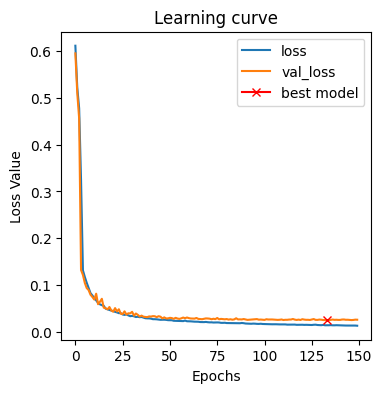

In [336]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(model_histogram.history["loss"], label="loss")
plt.plot(model_histogram.history["val_loss"], label="val_loss")
plt.plot( np.argmin(model_histogram.history["val_loss"]),
         np.min(model_histogram.history["val_loss"]),
         marker="x", color="r", label="best model")

plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend()
plt.show()


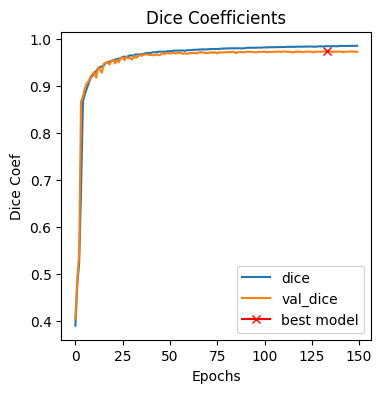

In [337]:
plt.figure(figsize=(4, 4))
plt.title("Dice Coefficients")
plt.plot(model_histogram.history['dice_coef'], label="dice")
plt.plot(model_histogram.history['val_dice_coef'], label="val_dice")
plt.plot( np.argmax(model_histogram.history["val_dice_coef"]),
         np.max(model_histogram.history["val_dice_coef"]),
         marker="x", color="r", label="best model")

plt.xlabel("Epochs")
plt.ylabel("Dice Coef")
plt.legend()
plt.show()